<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/main/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/bproj-dataset/traffic-sign-yolo.zip" -d "/content/home"

Archive:  /content/drive/MyDrive/bproj-dataset/traffic-sign-yolo.zip
   creating: /content/home/traffic-sign-yolo/
  inflating: /content/home/traffic-sign-yolo/00000.jpg  
  inflating: /content/home/traffic-sign-yolo/00000.txt  
  inflating: /content/home/traffic-sign-yolo/00001.jpg  
  inflating: /content/home/traffic-sign-yolo/00001.txt  
  inflating: /content/home/traffic-sign-yolo/00002.jpg  
  inflating: /content/home/traffic-sign-yolo/00002.txt  
  inflating: /content/home/traffic-sign-yolo/00003.jpg  
  inflating: /content/home/traffic-sign-yolo/00003.txt  
  inflating: /content/home/traffic-sign-yolo/00004.jpg  
  inflating: /content/home/traffic-sign-yolo/00004.txt  
  inflating: /content/home/traffic-sign-yolo/00005.jpg  
  inflating: /content/home/traffic-sign-yolo/00005.txt  
  inflating: /content/home/traffic-sign-yolo/00006.jpg  
  inflating: /content/home/traffic-sign-yolo/00006.txt  
  inflating: /content/home/traffic-sign-yolo/00007.jpg  
  inflating: /content/home/tra

In [3]:
!pip install nengo
!pip install nengo-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nengo-dl: filename=nengo_dl-3.6.0-py3-none-any.whl size=204190 sha256=f7892c9022612ebae374e43b0df9bf3b5c06217c76953b9dc198b2329f3f6c2e
  Stored in directory: /root/.cache/pip/wheels/99/98/1a/c238f79c953dec26b4345dc4aa1a9b7b0b250bac1018985465
Successfully built nengo-dl


In [4]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

### Load Data

In [5]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
MINIBATCH_SIZE = 32

In [6]:
dir_path = '/content/home/'

In [7]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Data Preprocessing

In [8]:
np.array(image_list).shape

(741, 240, 240, 3)

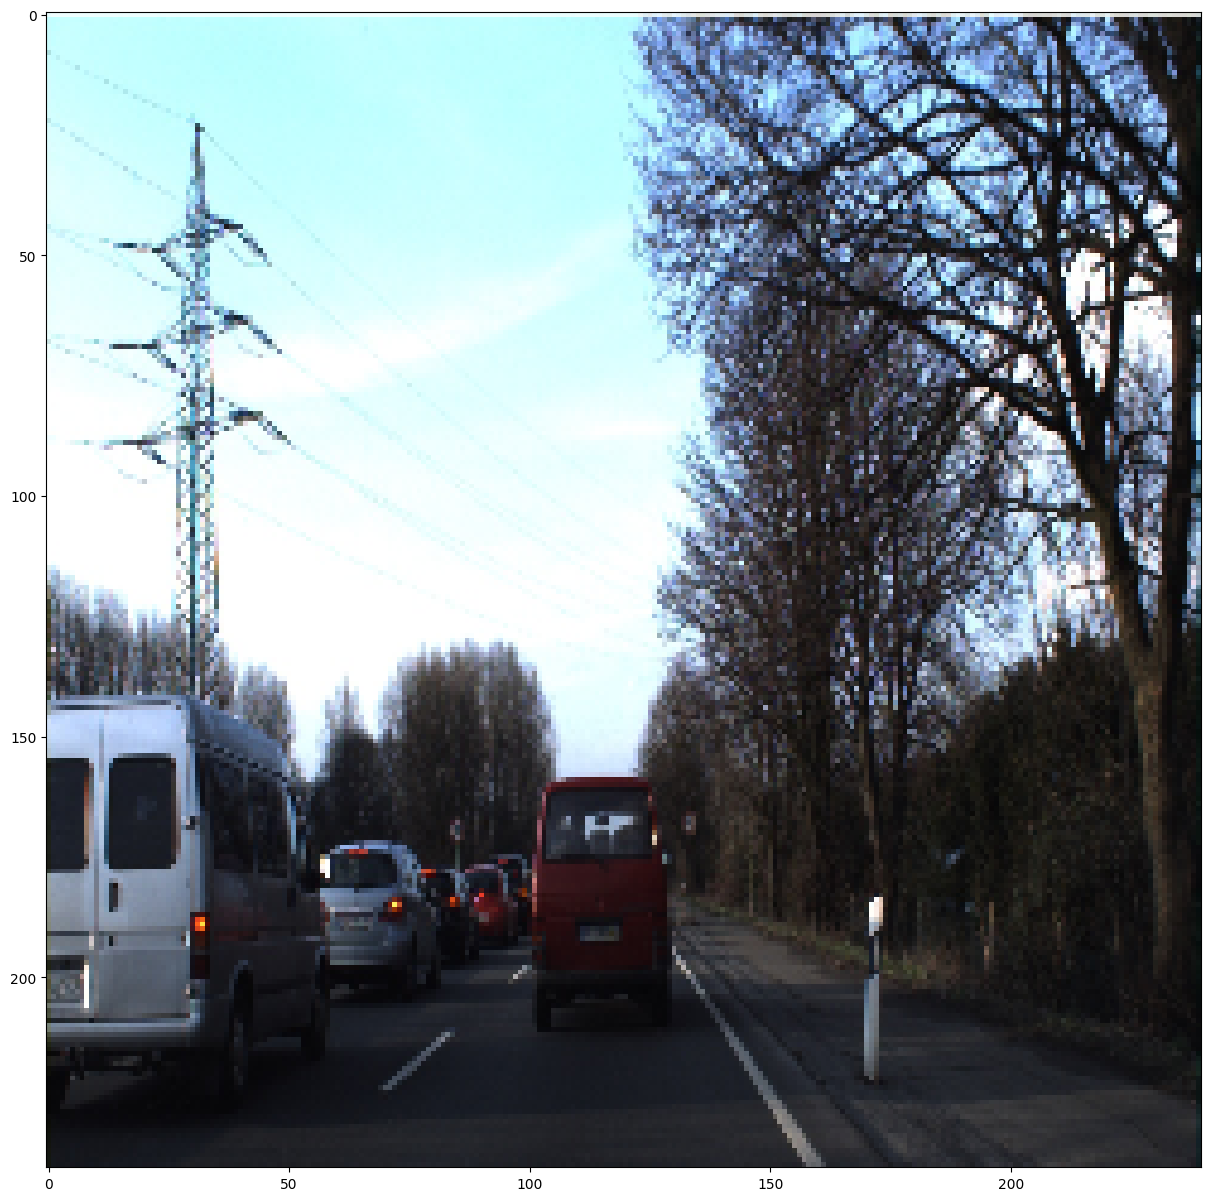

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(image_list[8])
plt.show()

In [10]:
train_data = np.reshape(image_list, (len(image_list), -1))

In [11]:
train_data.shape

(741, 172800)

### Autoencoder Network

In [12]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear() 
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 512

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")

In [13]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.predict(np.ones((MINIBATCH_SIZE, 1, n_in)));

|############         Building network (20%)                     | ETA: 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Build finished in 0:00:10                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


1/1 [==============================] - 3s 3s/step


### Train Model

In [16]:
for net_ens in auto_net.all_ensembles:
  net_ens.gain = nengo.dists.Choice([1])
  net_ens.bias = nengo.dists.Choice([0])

In [17]:
for conn in auto_net.all_connections:
  conn.synapse = None 